#HW 10 CLUSTERING BUSINESS

#cluster time trends in NYC businesses: 
#DATA
#Census Business data:
##download census data for businesses by ZIP code. the data is here
http://www.census.gov/econ/cbp/download/
##and it can be downloaded by hand. you can also download it with 3 terminal commands as follows: the data from 1993 through 2001 is different in the format of its path than the data after 2001 (that is why more than one for loop is needed)



In [1]:
kelly_colors_hex = [
    '#FFB300', # Vivid Yellow
    '#803E75', # Strong Purple
    '#FF6800', # Vivid Orange
    '#A6BDD7', # Very Light Blue
    '#C10020', # Vivid Red
    '#CEA262', # Grayish Yellow
    '#817066', # Medium Gray
    '#007D34', # Vivid Green
    '#F6768E', # Strong Purplish Pink
    '#00538A', # Strong Blue
    '#FF7A5C', # Strong Yellowish Pink
    '#53377A', # Strong Violet
    '#FF8E00', # Vivid Orange Yellow
    '#B32851', # Strong Purplish Red
    '#F4C800', # Vivid Greenish Yellow
    '#7F180D', # Strong Reddish Brown
    '#93AA00', # Vivid Yellowish Green
    '#593315', # Deep Yellowish Brown
    '#F13A13', # Vivid Reddish Orange
    '#232C16', # Dark Olive Green
    ]

In [2]:
# $ for ((y=93; y<=99; y+=1)); do wget ftp://ftp.census.gov/Econ2001_And_Earlier/CBP_CSV/zbp$y\totals.zip; done

# $ for ((y=0; y<=9; y+=1)); do wget ftp://ftp.census.gov/econ200$y\/CBP_CSV/zbp0$y\totals.zip; done

# $ for ((y=10; y<=15; y+=1)); do wget ftp://ftp.census.gov/econ20$y\/CBP_CSV/zbp$y\totals.zip; done


#NYC zip codes shape file is here
##http://data.nycprepared.org/dataset/nyc-zip-code-tabulation-areas/resource/0c0e14e9-78e1-404e-97b0-c2fabceb3981


NOTES: 
to read in a zip file without unzipping it you can use the pandas and zipfile packages

In [3]:
import pandas as pd
import zipfile 
import glob, os
import numpy as np
import pylab as pl
import json
import urllib.request

%pylab inline

#NYC zip codes shape file
# url = "https://nycdatastables.s3.amazonaws.com/2013-08-19T18:18:28.877Z/nyc-zip-code-tabulation-areas-polygons.geojson"
# request = urllib.request.urlopen(url)
nycsh = json.load(open('nyc-zip-code-tabulation-areas-polygons.geojson'))

Populating the interactive namespace from numpy and matplotlib


In [4]:
nyc_zip = []
for department in nycsh['features']:
    nyc_zip.append(str(department['properties']["postalCode"]))

In [5]:
os.chdir(".")

fname = "zbp00totals.zip"
zf = zipfile.ZipFile(fname)
biz = pd.read_csv(zf.open(fname.replace('.zip','.txt')))
biz = biz.rename(columns={'zip': 'ZIP', 'est': 'EST'})
biz_est_zip_year = biz[['ZIP', 'EST']]
biz_est_zip_year = biz_est_zip_year[(biz_est_zip_year.ZIP.astype(str).isin(nyc_zip))]
biz_est_zip_year['YEAR'] = 2000

for fname in glob.glob("*.zip"):
    if fname == "zbp00totals.zip":
        continue
    zf = zipfile.ZipFile(fname)
    df = pd.read_csv(zf.open(fname.replace('.zip','.txt')))
    df = df.rename(columns={'zip': 'ZIP', 'est': 'EST'})
    df = df[['ZIP', 'EST']]
    df = df[(df.ZIP.astype(str).isin(nyc_zip))]
    if int(fname[3:5]) > 93:
        df['YEAR'] = int('19' + fname[3:5])
    else:
        df['YEAR'] = int('20' + fname[3:5])
    biz_est_zip_year = biz_est_zip_year.append(df, ignore_index=True)

In [6]:
biz_est_zip = pd.DataFrame(np.nan,index=sorted(unique(biz_est_zip_year.ZIP)),columns=range(1994,2014))

In [7]:
biz_est_zip.loc[biz_est_zip.index==10001][1994]

10001   NaN
Name: 1994, dtype: float64

In [8]:
for z in biz_est_zip.index:
    for y in biz_est_zip.columns:
        biz_est = biz_est_zip_year[(biz_est_zip_year.ZIP == int(z)) & (biz_est_zip_year.YEAR == y)]
        if len(biz_est) != 0:
            biz_est_zip.loc[z, y] = int(biz_est.EST.values[0])

In [9]:
biz_est_zip.head()

,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013
10001,6999,7088,7075,7154,7254,7233,7317,7188,7141,7084,7370,7312,7415,7549,7472,7305,7241,7227,7235,7273
10002,1784,1819,1919,2049,2003,2085,2277,2543,2269,2402,2551,2682,2686,2685,2691,2775,2872,2912,2954,2988
10003,3256,3377,3417,3535,3649,3659,3683,3602,3616,3704,3776,3867,3909,4049,4071,4099,4113,4159,4214,4277
10004,1115,1124,1133,1173,1176,1233,1294,1247,1253,1252,1283,1260,1311,1370,1376,1379,1398,1404,1442,1479
10005,1076,1109,1216,1227,1270,1242,1287,1249,1244,1200,1226,1214,1259,1273,1291,1274,1266,1301,1273,1296


In [10]:
# WHITENING
wbiz_est_zip = biz_est_zip.copy()
for i in range(len(biz_est_zip)):
    wbiz_est_zip.iloc[i] = (wbiz_est_zip.iloc[i]-np.mean(wbiz_est_zip.iloc[i]))/np.std(wbiz_est_zip.iloc[i])

In [11]:
# CHECK
print("STD = {0}".format(np.std(wbiz_est_zip.loc[10005])))
print("MEAN = {0:.2f}".format(np.mean(wbiz_est_zip.loc[10005])))

STD = 1.0
MEAN = -0.00


In [12]:
wbiz_est_zip.iloc[1].index

Int64Index([1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004,
            2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013],
           dtype='int64')

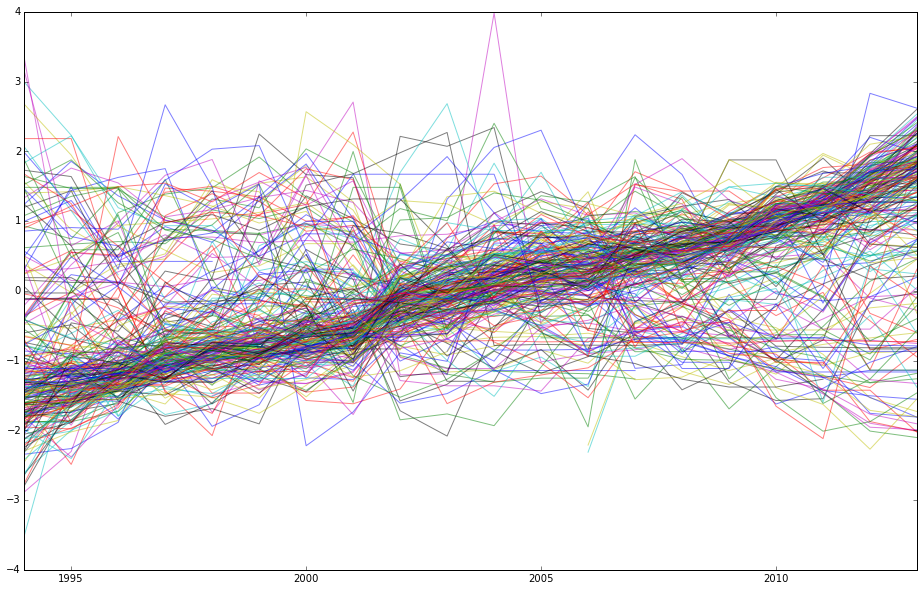

In [13]:
plt.figure(figsize=(16,10))
plt.xlim(1994,2013)
for i in range(len(wbiz_est_zip)):
    plt.plot(wbiz_est_zip.iloc[i].index, wbiz_est_zip.iloc[i], '-', alpha=0.5)

In [14]:
import sklearn.cluster
from sklearn import mixture
from PIL import Image
from scipy.misc import imread
from scipy.cluster.vq import kmeans2
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.cluster import DBSCAN
from descartes import PolygonPatch

In [15]:
wbiz_est_zip.head()

,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013
10001,-1.831632,-1.173250,-1.269418,-0.685012,0.054742,-0.100607,0.520787,-0.433496,-0.781180,-1.202840,0.912857,0.483799,1.245746,2.237017,1.667406,0.432016,-0.041426,-0.144992,-0.085811,0.195295
10002,-1.722813,-1.631907,-1.372173,-1.034519,-1.153997,-0.941015,-0.442326,0.248565,-0.463105,-0.117659,0.269344,0.609595,0.619984,0.617387,0.632971,0.851147,1.103089,1.206982,1.316071,1.404380
10003,-1.872528,-1.457250,-1.319968,-0.914985,-0.523731,-0.489411,-0.407041,-0.685038,-0.636989,-0.334968,-0.087861,0.224456,0.368602,0.849090,0.924595,1.020693,1.068741,1.226616,1.415379,1.631598
10004,-1.608897,-1.523770,-1.438643,-1.060302,-1.031926,-0.492790,0.084181,-0.360370,-0.303619,-0.313078,-0.019863,-0.237409,0.244976,0.803030,0.859781,0.888157,1.067869,1.124620,1.484044,1.834010
10005,-2.885957,-2.304004,-0.417066,-0.223082,0.535220,0.041442,0.835014,0.164887,0.076712,-0.699225,-0.240717,-0.452336,0.341236,0.588125,0.905554,0.605760,0.464681,1.081903,0.588125,0.993729


In [16]:
wbiz_est_zip = wbiz_est_zip.dropna()

# KMeans Clustering 

/Users/MSAUSI2015/anaconda/lib/python3.4/site-packages/matplotlib/axes/_axes.py:475: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "
/Users/MSAUSI2015/anaconda/lib/python3.4/site-packages/matplotlib/pyplot.py:424: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


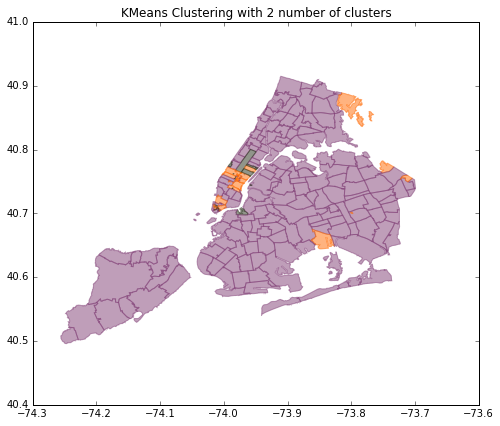

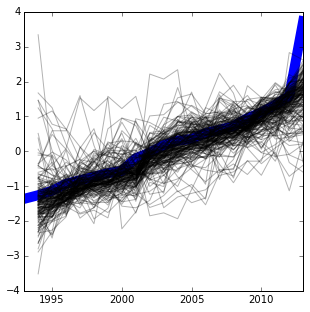

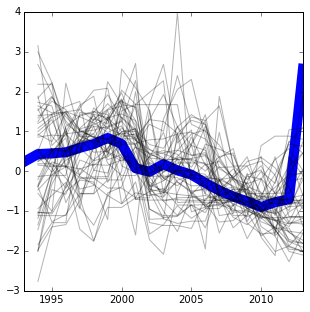

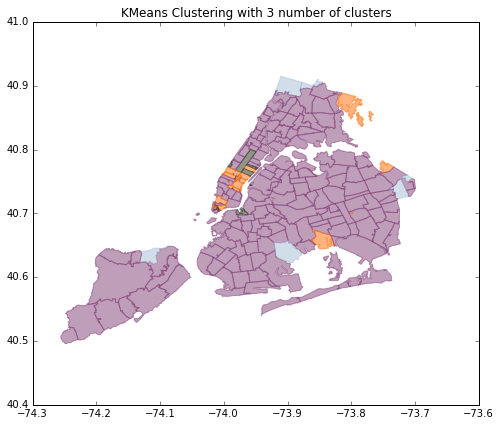

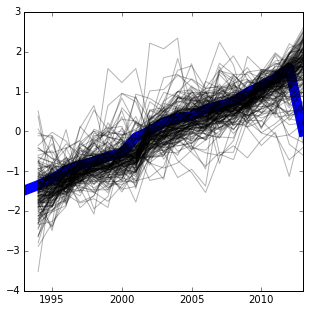

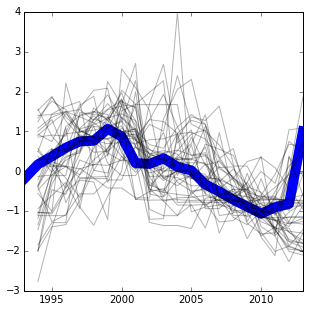

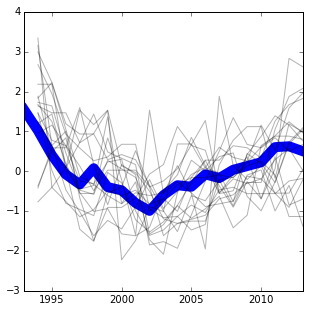

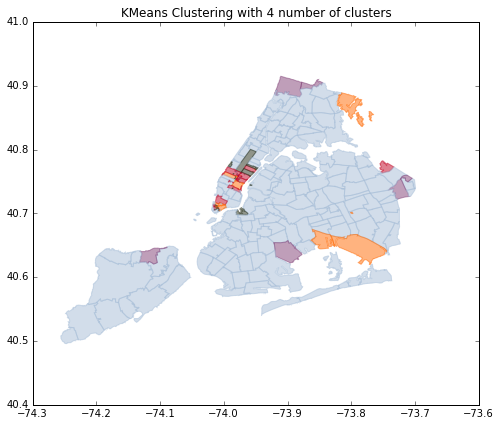

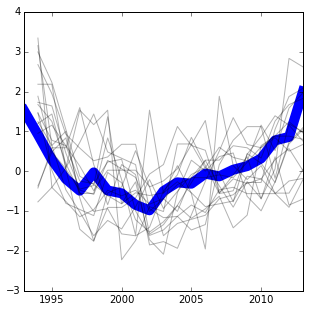

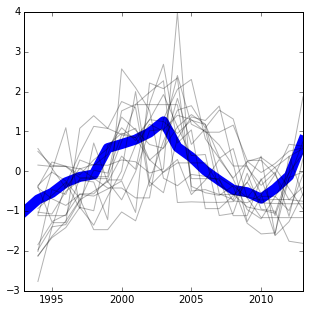

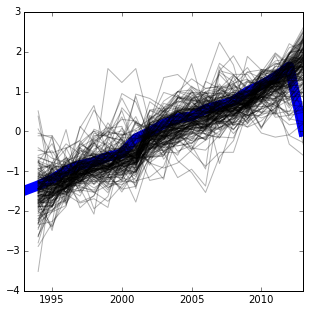

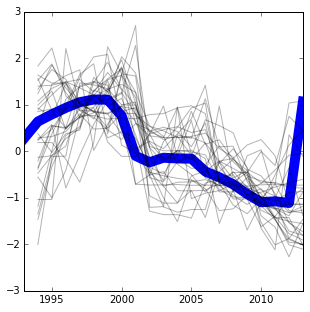

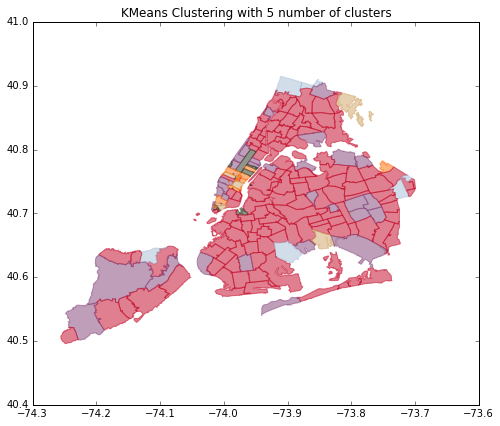

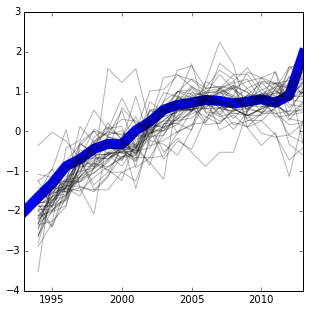

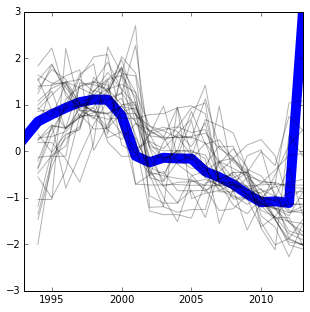

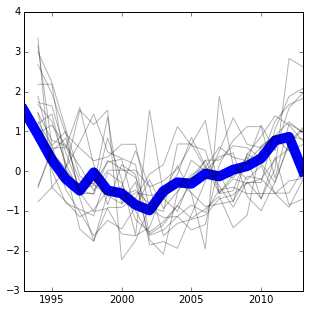

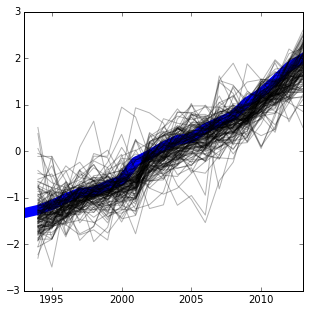

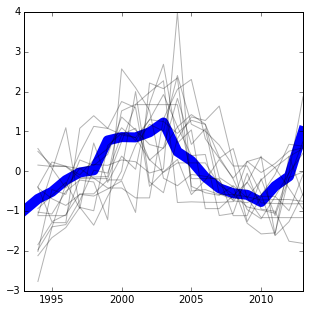

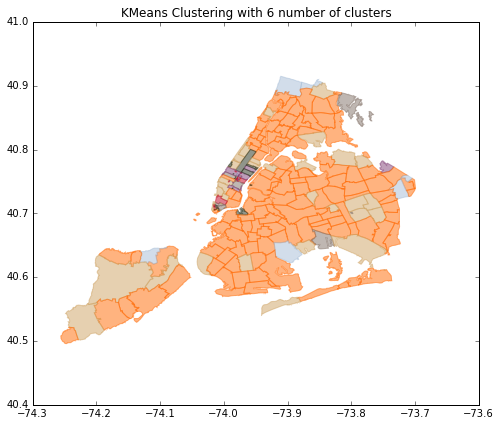

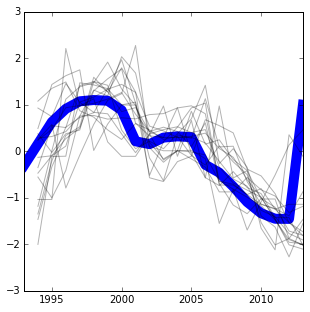

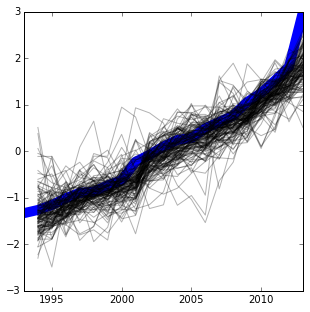

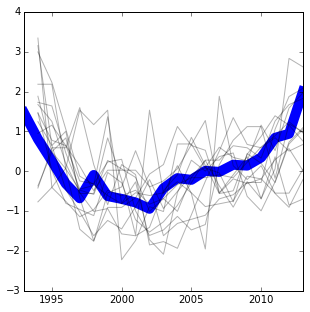

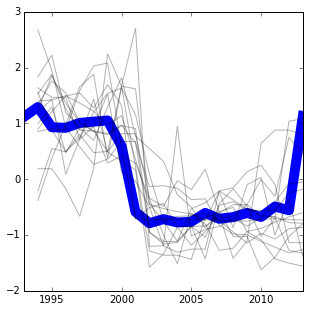

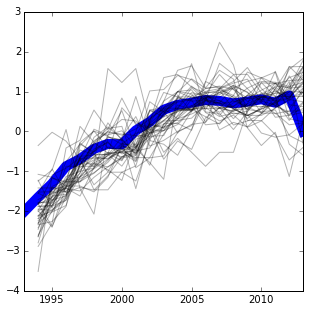

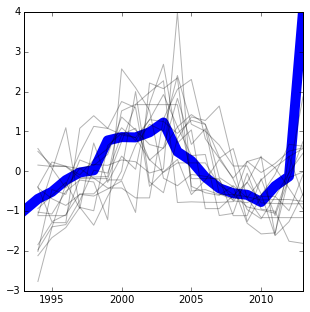

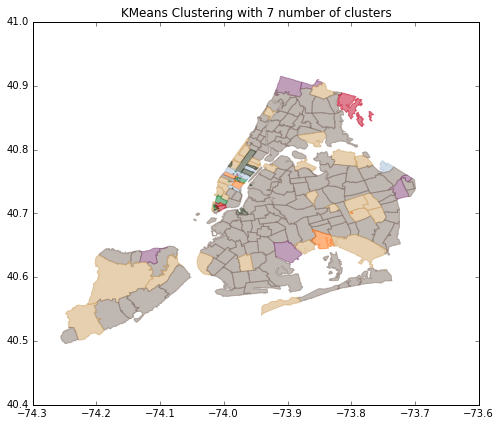

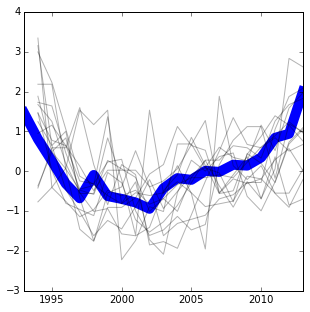

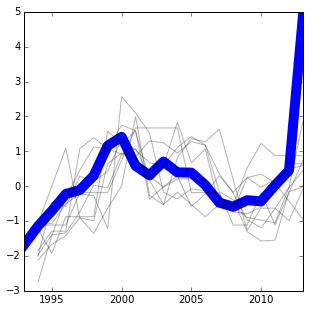

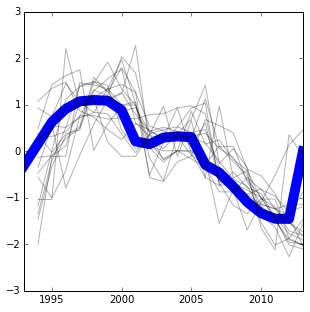

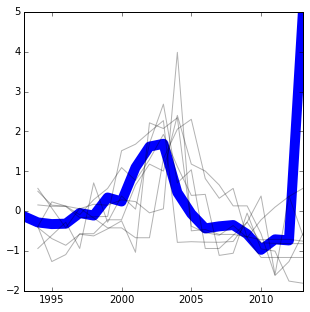

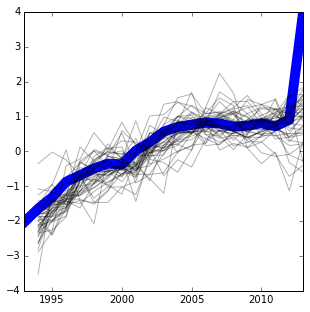

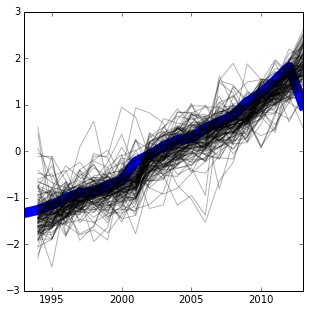

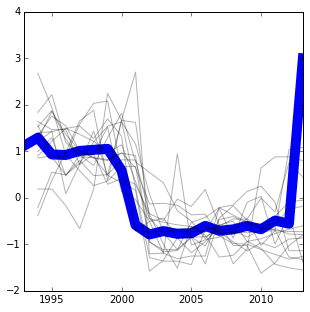

In [55]:
silhouette_scores = {}
for n_c in range(2,8):
    #Clustering
    kmeans = sklearn.cluster.KMeans(n_clusters=n_c)
    kmeans.fit(wbiz_est_zip.values)
    labels = kmeans.labels_
    centers = kmeans.cluster_centers_
    
    #Silhouette score
    
    silhouette_avg = silhouette_score(wbiz_est_zip.values, kmeans.labels_)
    silhouette_scores[n_c] = silhouette_avg
    
    #Plotting 
    cluster = labels
    clustered_zips = pd.DataFrame({'zip':wbiz_est_zip.index, 'cluster':cluster})
    fig = plt.figure(figsize=(8,8)) 
    plt.title('KMeans Clustering with %s number of clusters'%(n_c))
    for i in nycsh['features']:
        poly = i['geometry']
        postcode = int(i['properties']['postalCode'])
        ax = fig.gca()
        GREEN = kelly_colors_hex[19]
        if postcode in list(wbiz_est_zip.index):
            color = kelly_colors_hex[int(clustered_zips[clustered_zips['zip']==postcode]['cluster'])+1]
            ax.add_patch(PolygonPatch(poly, fc=color, ec=color, alpha=0.5, zorder=2 ))
        else:
            ax.add_patch(PolygonPatch(poly, fc=GREEN, ec=GREEN, alpha=0.5, zorder=2 ))
    ax.axis('scaled')
    import matplotlib.patches as mpatches

    ground = mpatches.Patch(color=GREEN, alpha=0.5, label='Ground')
    plt.legend()
   
    
    # Plotting lines
    clustered = wbiz_est_zip
    clustered['cluster'] = labels

    for i in range(len(centers)):
        clustered = pd.DataFrame()
        clustered = wbiz_est_zip
        clustered['cluster'] = labels
        plt.figure(figsize=(5,5))
        plt.xlim(1993,2013)
        plt.plot(range(1993,2014), centers[i],linewidth=10) 
        i_cluster = clustered[clustered['cluster'] == i]
        i_cluster = i_cluster.drop('cluster', 1)
        for j in range(len(i_cluster)):
            plt.plot(i_cluster.iloc[j].index, i_cluster.iloc[j],'k',alpha=0.3)

In [117]:
for sc in silhouette_scores:
    print('For {0} number of centerters  silhouette value={1}'.format(sc, silhouette_scores[sc]))

For 2 number of centerters  silhouette value=0.5616111357422497
For 3 number of centerters  silhouette value=0.5215459771612735
For 4 number of centerters  silhouette value=0.42388512067030387
For 5 number of centerters  silhouette value=0.2176634110558894
For 6 number of centerters  silhouette value=0.25882755717599915
For 7 number of centerters  silhouette value=0.21228899517007513
For 8 number of centerters  silhouette value=0.14997786423853882
For 9 number of centerters  silhouette value=0.1732029389719644


# Based on the silhouette score, mapping, and plotting for KMeans clustering 3 centers looks better than others

In [41]:
#Left intentionally 

# DBSCAN Clustering 

In [59]:
wbiz_est_zip.T.describe()

,10001,10002,10003,10004,10005,10006,10007,10009,10010,10011,...,11433,11434,11435,11436,11451,11691,11692,11693,11694,11697
count,21.000000,21.000000,21.000000,21.000000,21.000000,21.000000,21.000000,21.000000,21.000000,21.000000,...,21.000000,21.000000,21.000000,21.000000,21.000000,21.000000,21.000000,21.000000,21.000000,21.000000
mean,0.190476,0.238095,0.238095,0.238095,0.190476,0.285714,0.142857,0.238095,0.095238,0.190476,...,0.190476,0.238095,0.238095,0.238095,0.047619,0.238095,0.238095,0.238095,0.238095,0.190476
std,1.327368,1.480026,1.480026,1.480026,1.327368,1.647509,1.195229,1.480026,1.091089,1.327368,...,1.327368,1.480026,1.480026,1.480026,1.023533,1.480026,1.480026,1.480026,1.480026,1.327368
min,-1.831632,-1.722813,-1.872528,-1.608897,-2.885957,-1.142654,-1.034117,-1.744005,-1.692683,-2.187392,...,-2.190038,-1.676493,-1.432328,-1.368542,-1.114172,-1.428153,-1.533257,-1.257237,-1.420958,-1.724425
25%,-0.685012,-0.941015,-0.636989,-0.492790,-0.240717,-0.863958,-0.606033,-0.750419,-0.553445,-0.512995,...,-0.444503,-0.767695,-0.917334,-0.979909,-1.114172,-0.838431,-0.634279,-0.728986,-0.815006,-0.674014
50%,-0.041426,0.269344,-0.087861,-0.019863,0.341236,-0.608487,-0.379400,0.283840,0.009142,0.217447,...,0.367374,0.061384,0.091197,0.297026,-0.185695,0.110252,-0.234733,-0.306386,-0.269649,0.026260
75%,0.520787,0.851147,1.020693,0.888157,0.605760,1.156589,0.367649,0.771918,0.754570,0.846751,...,0.651531,0.938294,0.885147,0.963254,0.742781,0.751255,0.764131,1.278367,1.124041,1.076671
max,4.000000,5.000000,5.000000,5.000000,4.000000,6.000000,3.000000,5.000000,2.034455,4.000000,...,4.000000,5.000000,5.000000,5.000000,1.671258,5.000000,5.000000,5.000000,5.000000,4.000000


[-1  0  1]
Silhouette Coefficient: 0.441286982294
Estimated number of clusters: 2


/Users/MSAUSI2015/anaconda/lib/python3.4/site-packages/matplotlib/axes/_axes.py:475: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


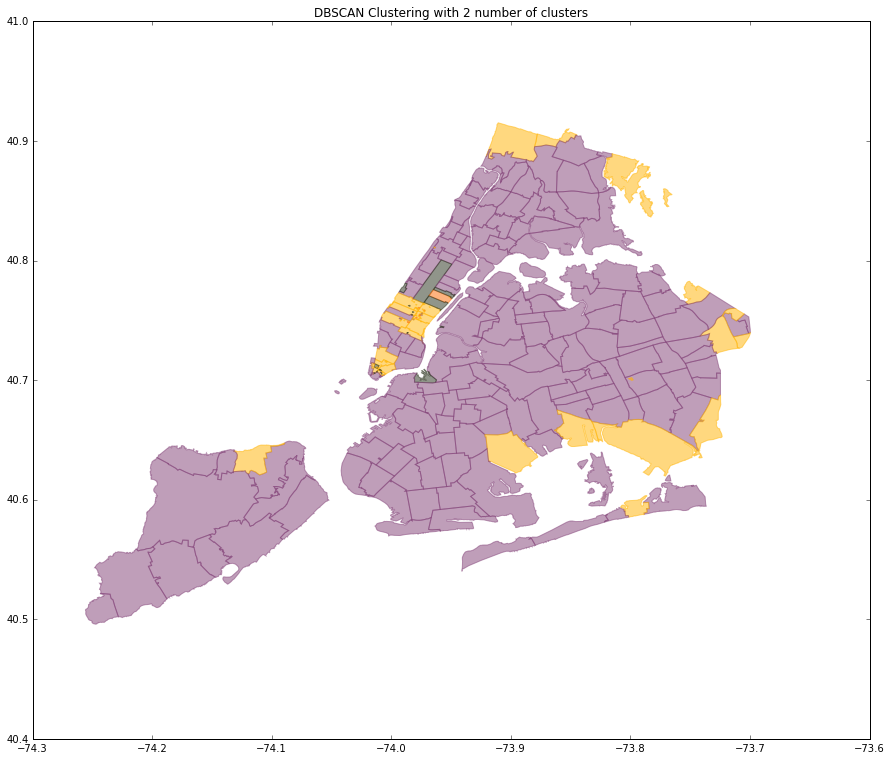

In [63]:
# eps selected as 2
db = DBSCAN(eps=2).fit(wbiz_est_zip.values)

labels = (db.labels_).astype(int)
n_clusters = len(set(labels)) - (1 if -1 in labels else 0)

print(unique(labels))
print("Silhouette Coefficient: %s" % silhouette_score(wbiz_est_zip.values, labels))
print('Estimated number of clusters: %d' % n_clusters)

cluster = labels
clustered_zips = pd.DataFrame({'zip':wbiz_est_zip.index, 'cluster':cluster})
fig = plt.figure(figsize=(15,15)) 
for i in nycsh['features']:
    poly = i['geometry']
    postcode = int(i['properties']['postalCode'])
    ax = fig.gca()
    GREEN = kelly_colors_hex[19]
    if postcode in list(wbiz_est_zip.index):
        color = kelly_colors_hex[int(clustered_zips[clustered_zips['zip']==postcode]['cluster'])+1]
        ax.add_patch(PolygonPatch(poly, fc=color, ec=color, alpha=0.5, zorder=2 ))
    else:
        ax.add_patch(PolygonPatch(poly, fc=GREEN, ec=GREEN, alpha=0.5, zorder=2 ))
ax.axis('scaled')
import matplotlib.patches as mpatches

ground = mpatches.Patch(color=GREEN, alpha=0.5, label='Ground')
plt.legend()
plt.title('DBSCAN Clustering with %s number of clusters'%(n_clusters))

# KMeans with 3 clusters

/Users/MSAUSI2015/anaconda/lib/python3.4/site-packages/matplotlib/axes/_axes.py:475: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


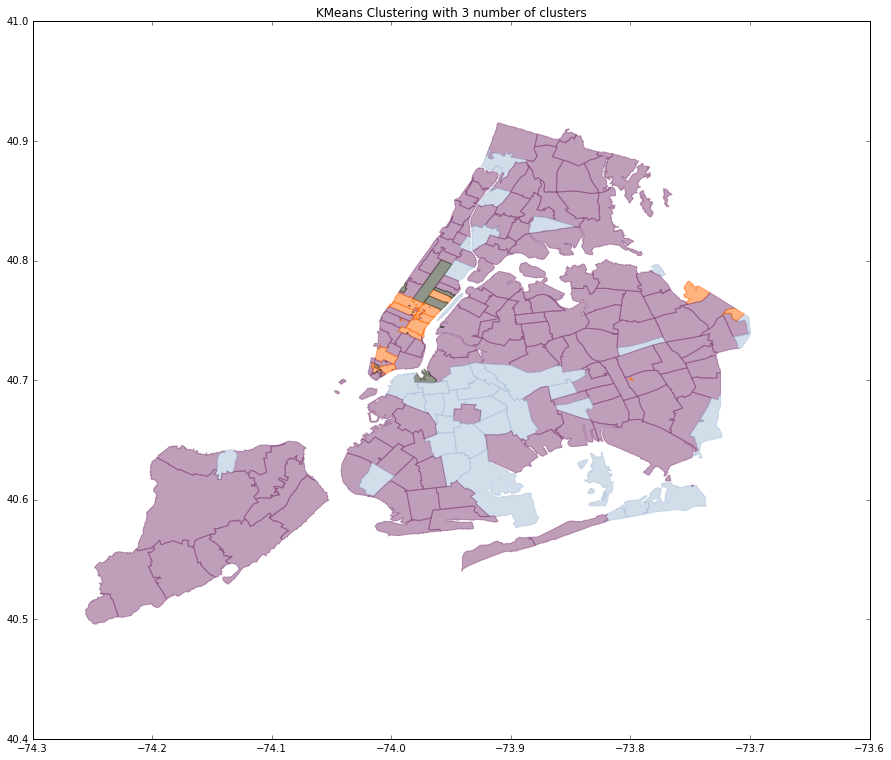

In [54]:
kmeans3 = sklearn.cluster.KMeans(n_clusters=3)
kmeans3.fit(wbiz_est_zip.values)
labels = kmeans3.labels_
centers = kmeans3.cluster_centers_

#Plotting 
cluster = labels
clustered_zips = pd.DataFrame({'zip':wbiz_est_zip.index, 'cluster':cluster})
fig = plt.figure(figsize=(15,15)) 
plt.title('KMeans Clustering with %s number of clusters'%(3))
for i in nycsh['features']:
    poly = i['geometry']
    postcode = int(i['properties']['postalCode'])
    ax = fig.gca()
    GREEN = kelly_colors_hex[19]
    if postcode in list(wbiz_est_zip.index):
        color = kelly_colors_hex[int(clustered_zips[clustered_zips['zip']==postcode]['cluster'])+1]
        ax.add_patch(PolygonPatch(poly, fc=color, ec=color, alpha=0.5, zorder=2 ))
    else:
        ax.add_patch(PolygonPatch(poly, fc=GREEN, ec=GREEN, alpha=0.5, zorder=2 ))
ax.axis('scaled')
import matplotlib.patches as mpatches

ground = mpatches.Patch(color=GREEN, alpha=0.5, label='Ground')
plt.legend()


# 6. Compare the results of the 2 algorithms

# Both algorithm depends on the choosing right parameter
* for K Means choosing center - we can see visualization or silhoute score to select it

* for DBSCAN choosing treshold value ep is hard, we have to know the data very well.
 (ep = The maximum distance between two samples for them to be considered as in the same neighborhood.)

# KMeans performed better than DBSCAN for this case.
   * DBSCAN clustered downtown Manhattan and Times Square with outher areas which is does not make sense. Hence I would choose KMeans for this case 


# 7. attempt an interpretation. this is dangerous ground: clustering is an exploratory tool so you do not want to jump to conclusions because you see some clusters! but seeing structure in your data can inform your next moves as an investigator. 

## Highly Commercial areas (orange in Kmeans 3 cluster) , 
## residential area ( Pink in Kmeans 3 cluster) 
## And underdeveloped areas ( light blue in Kmeans 3 cluster)
## However some outer areas are alos orange which are non commercial areas. 
## But It is enough for next move, in my opinion